# Plotting

In [10]:
# import packages 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import warnings
from PIL import Image

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

preprocessed_folder = "../../data/07_masked_and_smooth"
filename = 'DatasetInfo.csv'
dataframe = pd.read_csv(os.path.join(preprocessed_folder,filename))
dataframe = dataframe[dataframe["channel"]=="C2"]
dataframe.head()

,Unnamed: 0,file name,channel,image quality,notes,folder,full path,original file name,type
0,0,Projected_C2-D3_en_pnr_male_02_20221025.tif,C2,undefined,none,../../data/07_masked_and_smooth/,../../data/06_warped/Projected_C2-D3_en_pnr_ma...,D3_en_pnr_male_02_20221025.tif,D3-pnr
3,3,Projected_C2-D3_En_male_07_20220715.tif,C2,undefined,none,../../data/07_masked_and_smooth/,../../data/06_warped/Projected_C2-D3_En_male_0...,D3_En_male_07_20220715.tif,D3
6,6,Projected_C2-D3_En_male_03_20220805.tif,C2,undefined,none,../../data/07_masked_and_smooth/,../../data/06_warped/Projected_C2-D3_En_male_0...,D3_En_male_03_20220805.tif,D3
9,9,Projected_C2-D0_En_pn_male_06_20220708.tif,C2,undefined,none,../../data/07_masked_and_smooth/,../../data/06_warped/Projected_C2-D0_En_pn_mal...,D0_En_pn_male_06_20220708.tif,D0-pnr
12,12,Projected_C2-D0_En_pn_male_01_20220705.tif,C2,undefined,none,../../data/07_masked_and_smooth/,../../data/06_warped/Projected_C2-D0_En_pn_mal...,D0_En_pn_male_01_20220705.tif,D0-pnr


#### Average phenotype plot

In [3]:
%matplotlib widget

def average_phenotype(dataframe, folder, construct=None, quality=None):
    if construct:
        dataframe = dataframe[dataframe['type']==construct]
    if quality:
        dataframe = dataframe[dataframe['image quality']==quality]
    
    image_names = dataframe["file name"].values
    print(len(image_names))
    
    temp_image = Image.open(os.path.join(folder,image_names[0]))
    image = np.asarray(temp_image)/len(image_names)
    
    for image_file_name in image_names[1:]:
        temp_image = Image.open(os.path.join(folder,image_file_name))
        temp_image = np.asarray(temp_image)/len(image_names)
        image = (image + temp_image)
        
    return image

3
2


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
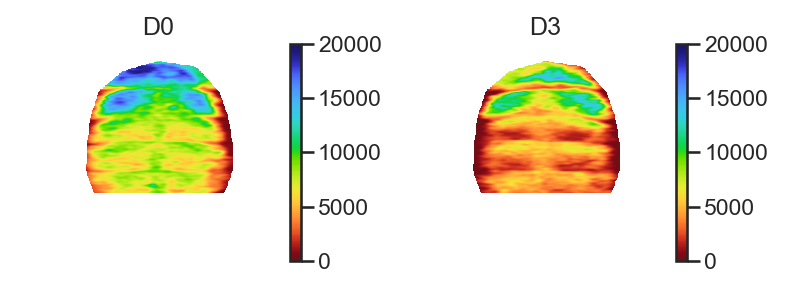

In [13]:
import matplotlib.colors as clr
import numpy.ma as ma

colormap = "../../data/References_and_masks//jetblack_colormap_yann.lut"
colors = np.genfromtxt(colormap, delimiter = ",")/255
colors = np.flipud(colors)
jetblack = clr.LinearSegmentedColormap.from_list('custom_jet', colors, N=255)

mask_filename = '../../data/07_masked_and_smooth/mask_C2.tif'
mask = 1-np.asarray(Image.open(mask_filename))

construct1 = "D0-pnr"
construct2 = "D3"

cmap = jetblack 

xlim = [0,320]
ylim = [0,300]

D0 = average_phenotype(dataframe, preprocessed_folder, construct=construct1)
D3 = average_phenotype(dataframe, preprocessed_folder, construct=construct2)

D0 = ma.masked_array(D0, mask=mask)
D3 = ma.masked_array(D3, mask=mask)

fig, axes = plt.subplots(1,2,figsize=(8, 3))

im0 = axes[0].imshow(D0,   cmap=cmap)
axes[0].set_title("D0")
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].axis('off')
im0.set_clim(0,20000)
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(D3,   cmap=cmap)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_title("D3")
axes[1].axis('off')
im1.set_clim(0,20000)
fig.colorbar(im1, ax=axes[1])


plt.tight_layout()


# PCA Analysis

The following cells perform a Principal Component Analysis of the images in the dataset, the first n components of the pca space are defined based on all the images in the dataset or on their averages for each group (e.g. the set of averages for each genotype).
Each image is then represented in the PCA space.

In [1]:
# import packages 
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import warnings

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

from src.pca_analysis import *
import matplotlib.colors as clr

# whether to use all of the images or only the averages of each group
# to define the components of the pca space:

averages_pca_space = True
n_components = 4

colormap = "../../data/References_and_masks/jetblack_colormap_yann.lut"
colors = np.genfromtxt(colormap, delimiter = ",")/255
colors = np.flipud(colors)
jetblack = clr.LinearSegmentedColormap.from_list('custom_jet', colors, N=255)

preprocessed_folder = "../../data/07_masked_and_smooth"
filename = 'DatasetInfo.csv'
dataframe = pd.read_csv(os.path.join(preprocessed_folder,filename))
mask_filename = '../../data/References_and_masks/mask_2d.tif'

dataframe = dataframe[dataframe["channel"]=="C2"]
dataframe = dataframe[dataframe["image quality"]!="bad"]
dataframe = dataframe.reset_index()

### Option 1:
if not averages_pca_space:
    dataframe = reshape_all_images_for_PCA(dataframe, mask_filename)
    dataframe, eigenvectors_dict = PCA_analysis(dataframe, n_components=n_components, column_for_PCA='I_reshaped')

### Option 2:
else:
    dataframe = reshape_averages_for_PCA(dataframe, mask_filename)
    dataframe, eigenvectors_dict = PCA_analysis(dataframe, n_components=n_components, column_for_PCA='average_I_reshaped')

dataframe = dataframe.reset_index()

Start PCA analysis


### PCA plots

The following cells visualize the results of the PCA analysis in a 2D space defined by two PCA components of choice. The second cell can be used to perform a change of base in the 2D PCA space.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
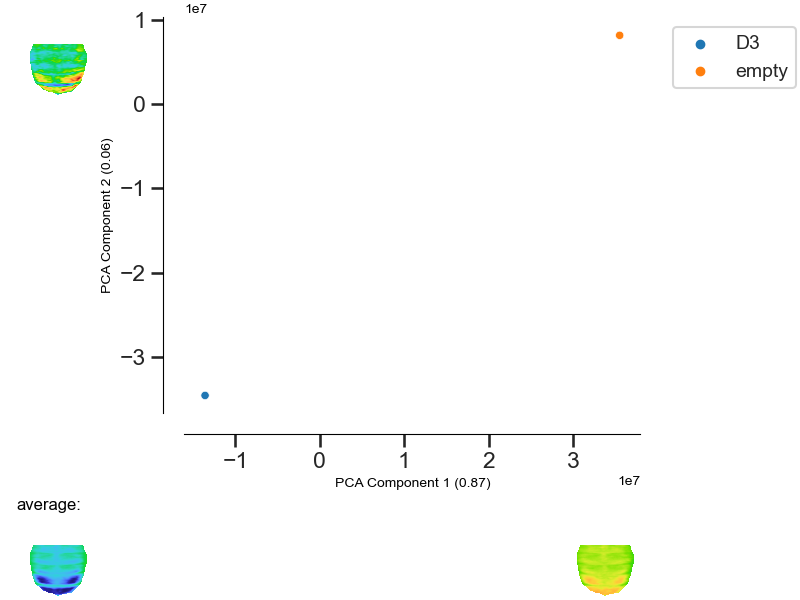

In [2]:
data_to_plot = dataframe[dataframe["type"].isin(["D4", "D3", "D0", "D3-4", "empty"])]
plot_PCA_2D(data_to_plot, eigenvectors_dict, comp1 = 1, comp2 = 2, hue='type', figsize=(8, 6), reverse_x=False, reverse_y=False, cmap=jetblack)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
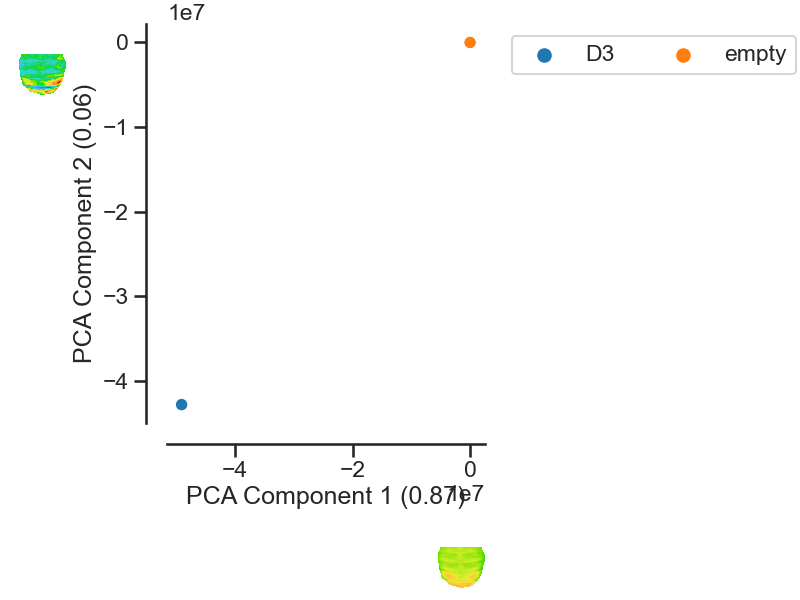

In [3]:
data_to_plot = dataframe[dataframe["type"].isin(["D4", "D3", "D0", "D3-4", "empty"])]
change_basis_and_plot_PCA_2D(data_to_plot, eigenvectors_dict, comp1 = 1, comp2 = 2, hue='type',
                       v1_x=1, v1_y=0, v2_x=0, v2_y=1, origin="empty", figsize=(8, 6), cmap=jetblack)